# NOTE
Questa versione arriva fino prima dell'addestamento del modello.

Esegue
- downoald dataset
- preparazione dataset

# Downlod del dataset

In [1]:
import os
if not os.path.exists('data.zip'):
  !wget https://www.dropbox.com/scl/fi/eiccn8qz2qkp9djqf8zdn/data.zip?rlkey=v28bqs6piwx2lxjr2k78e2r0g&dl=0

!mv data.zip* data.zip
!rm -r data
!rm -r data_aug
!unzip -q data.zip

mv: 'data.zip' and 'data.zip' are the same file
rm: cannot remove 'data_aug': No such file or directory


## **KerasCV**
La libreria [**KerasCV**](https://keras.io/keras_cv/) mette a disposizione componenti specifiche per svolgere task di *Computer Vision* come modelli pre-addestrati, metriche e layer.

La cella seguente permette di installare l'ultima versione di KerasCV.

In [2]:
!pip install --upgrade -q git+https://github.com/keras-team/keras-cv

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
!pip install imgaug

# **Import delle librerie**
Per prima cosa è necessario eseguire l'import delle librerie utilizzate durante l'esecitazione.

In [4]:
import os
import tensorflow as tf
import numpy as np
import keras_cv
import cv2
import random
import math
from tensorflow import keras
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

Using TensorFlow backend


# Funzioni di utilità

In [5]:
def prepare_dataset(dataset,batch_size,model_input_size):
  resizer = keras.Sequential(layers=[keras_cv.layers.Resizing(model_input_size,model_input_size,pad_to_aspect_ratio=True,bounding_box_format=bb_format)])

  ds = dataset.map(load_dataset_element, num_parallel_calls=tf.data.AUTOTUNE)
  ds = ds.shuffle(dataset.cardinality())
  ds = ds.ragged_batch(batch_size, drop_remainder=True)
  ds = ds.map(resizer, num_parallel_calls=tf.data.AUTOTUNE)
  ds = ds.map(lambda inputs: (inputs['images'], inputs['bounding_boxes']), num_parallel_calls=tf.data.AUTOTUNE)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

def plot_history(history):
  fig, ax1 = plt.subplots(figsize=(10, 8))

  epoch_count=len(history.history['loss'])

  line1,=ax1.plot(range(1,epoch_count+1),history.history['loss'],label='train_loss',color='orange')
  ax1.plot(range(1,epoch_count+1),history.history['val_loss'],label='val_loss',color = line1.get_color(), linestyle = '--')
  ax1.set_xlim([1,epoch_count])
  ax1.set_ylim([0, max(max(history.history['loss']),max(history.history['val_loss']))])
  ax1.set_ylabel('loss',color = line1.get_color())
  ax1.tick_params(axis='y', labelcolor=line1.get_color())
  ax1.set_xlabel('Epochs')
  _=ax1.legend(loc='lower left')

def compute_mean_average_precision(y_true, y_pred):
  coco_metrics=keras_cv.metrics.BoxCOCOMetrics(bounding_box_format='xywh',evaluate_freq=1)
  coco_metrics.update_state(y_true, y_pred)
  return coco_metrics.result(force=True)['MaP'].numpy()

# Funzioni di utilità per plottare le immagini e le relative bounding box

In [6]:
def plot_images_with_tlbr(images, boxes, class_ids, class_labels, image_per_row=4, show_labels=True,
                          confidences=None):
  class_colors = plt.cm.hsv(np.linspace(0, 1, len(class_labels) + 1)).tolist()
  image_count = len(images)
  row_count = math.ceil(image_count / image_per_row)
  col_count = image_per_row

  _, axs = plt.subplots(nrows=row_count, ncols=col_count, figsize=(18, 4 * row_count), squeeze=False)
  for r in range(row_count):
    for c in range(col_count):
      axs[r, c].axis('off')

  for i in range(image_count):
    r = i // image_per_row
    c = i % image_per_row

    axs[r, c].imshow(images[i])
    for box_idx in range(len(boxes[i])):
      box = boxes[i][box_idx]
      class_idx = class_ids[i][box_idx]
      color = class_colors[class_idx]
      xmin = box[0]
      ymin = box[1]
      xmax = box[2]
      ymax = box[3]
      w = xmax - xmin
      h = ymax - ymin
      axs[r, c].add_patch(plt.Rectangle((xmin, ymin), w, h, color=color, fill=False, linewidth=2))
      if show_labels:
        label = '{}'.format(class_labels[class_idx])
        if confidences is not None:
          label += ' {:.2f}'.format(confidences[i][box_idx])
        axs[r, c].text(xmin, ymin, label, size='large', color='white', bbox={'facecolor': color, 'alpha': 1.0})



def plot_images_with_y_preds(images,y_preds,class_labels,image_per_row=4,show_labels=True):
  image_count=images.shape[0]
  plot_images_with_tlbr(images,
                                      [y_preds['boxes'][i,:y_preds['num_detections'][i]] for i in range(image_count)],
                                      [y_preds['classes'][i,:y_preds['num_detections'][i]] for i in range(image_count)],
                                      class_labels,
                                      image_per_row=image_per_row,
                                      show_labels=show_labels,
                                      confidences=[y_preds['confidence'][i,:y_preds['num_detections'][i]] for i in range(image_count)])

# Utils per caricamento dataset

In [7]:
def load_images_paths_and_labels_paths_from_folder(folder):
  images_path = os.path.join(folder, 'images')
  labels_path = os.path.join(folder, 'labels')
  images = sorted(
    [os.path.join(images_path, filename) for filename in os.listdir(images_path)]
  )
  labels = sorted(
    [os.path.join(labels_path, filename) for filename in os.listdir(labels_path)]
  )
  return images, labels


def parse_yolov8_annotation(txt_file):
    yolov8_boxes = []
    class_ids = []
    with open(txt_file) as file:
      for line in file:
        splitted_line = line.split()
        class_ids.append(int(splitted_line[0]))
        rcx = float(splitted_line[1])
        rcy = float(splitted_line[2])
        rw = float(splitted_line[3])
        rh = float(splitted_line[4])
        rxmin=rcx-rw/2
        rymin=rcy-rh/2
        yolov8_boxes.append([rxmin, rymin, rw, rh]) #rel_xywh

    return yolov8_boxes, class_ids

def load_dataset_info(txt_file_list, images):
  image_yolov8_box_list = []
  image_class_id_list = []
  for txt_file in txt_file_list:
    yolov8_boxes, class_ids = parse_yolov8_annotation(txt_file)
    image_yolov8_box_list.append(yolov8_boxes)
    image_class_id_list.append(class_ids)

  return images, image_yolov8_box_list, image_class_id_list

def load_dataset_element(image_path, bboxes,classes):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    bounding_boxes = {
        'classes': tf.cast(classes, dtype=tf.float32),
        'boxes': bboxes,
    }
    return {'images': tf.cast(image, tf.float32), 'bounding_boxes': bounding_boxes}


# Parse top-left bottom-right absolute annotations utilities

In [8]:
def parse_tlbr_annotation(txt_file):
  tlbr_boxes = []
  class_ids = []
  with open(txt_file) as file:
    for line in file:
      splitted_line = line.split()
      class_ids.append(int(splitted_line[0]))
      tl_x = float(splitted_line[1])
      tl_y = float(splitted_line[2])
      br_x = float(splitted_line[3])
      br_y = float(splitted_line[4])
      tlbr_boxes.append([tl_x, tl_y, br_x, br_y])

  return tlbr_boxes, class_ids


def load_tlbr_dataset_info(txt_file_list, images):
  image_tlbr_box_list = []
  image_class_id_list = []
  for txt_file in txt_file_list:
    tlbr_boxes, class_ids = parse_tlbr_annotation(txt_file)
    image_tlbr_box_list.append(tlbr_boxes)
    image_class_id_list.append(class_ids)

  return images, image_tlbr_box_list, image_class_id_list


# Funzione utilità per conversione e salvataggio bounding box

In [9]:
def from_tlwh_to_tlbr(bboxes, images_path):
  tlbr_bboxes = []
  count = 0
  for bbox_list in bboxes:
    image = plt.imread(images_path[count])
    image_height, image_width = image.shape[:2]
    image_tlbr_bboxes = []
    for bbox in bbox_list:
      top_left_x = bbox[0] * image_width
      top_left_y = bbox[1] * image_height
      bottom_right_x = top_left_x + bbox[2] * image_width
      bottom_right_y = top_left_y + bbox[3] * image_height
      image_tlbr_bboxes.append([top_left_x, top_left_y, bottom_right_x, bottom_right_y])
    tlbr_bboxes.append(image_tlbr_bboxes)
    count += 1
  return tlbr_bboxes

def save_bboxes(bboxes, label_path):
  with open(label_path, 'w') as file:
    for bbox in bboxes:
      file.write('1 ' + ' '.join(map(str, bbox)) + '\n')


# Utilities per resizing e padding delle immagini

In [10]:
def resize_img(img_path, input_size):
  my_image = plt.imread(img_path)

  if max(my_image.shape[0], my_image.shape[1]) > input_size:
    if my_image.shape[0] >= my_image.shape[1]:
      height = input_size
      width = int(my_image.shape[1] * input_size / my_image.shape[0])
    else:
      width = input_size
      height = int(my_image.shape[0] * input_size / my_image.shape[1])
    my_image = cv2.resize(my_image, (width, height), interpolation=cv2.INTER_LINEAR)

  plt.imsave(img_path, my_image)


def pad_img(img_path, input_size):
  my_image = plt.imread(img_path)

  # Punto 5
  pad_width = input_size - my_image.shape[0]
  pad_height = input_size - my_image.shape[1]
  my_padded_image = np.pad(my_image,
                           ((0, pad_width), (0, pad_height), (0, 0)),
                           'constant')
  plt.imsave(img_path, my_padded_image)


# Preparazione iniziale dei dati


## Variabili globali di utilità

In [11]:
input_size = 512

class_labels = ['none', 'logo']
base_path='data'

bb_format = 'xyxy'

## Caricamento dei dati

In [12]:
images, labels = load_images_paths_and_labels_paths_from_folder(base_path)

## Rescaling

In [13]:
for img_path in images:
  resize_img(img_path, input_size)

## Caricamento, conversione e salvataggio delle bounding box da xywh a tlbr

In [14]:
img_paths, yolov8_boxes, id_list = load_dataset_info(labels, images)

tlbr_boxes = from_tlwh_to_tlbr(yolov8_boxes, img_paths)

for i in range(len(labels)):
  save_bboxes(tlbr_boxes[i], labels[i])


## Padding

In [15]:
for img_path in images:
  pad_img(img_path, input_size)

#YOLOv8
YOLOv8 è l'ultimo modello basato sull'architettura YOLO (*You Only Look Once*) in grado di individuare in tempo reale oggetti multipli all'interno di un'immagine con un elevato livello di accuratezza. Quest'ultima versione è in grado di supportare diversi tipi di *task* tra cui: *detection*, segmentazione e classificazione.

## **Creazione del modello**
Il codice seguente crea un'istanza della classe [**YOLOV8Detector**](https://keras.io/api/keras_cv/models/tasks/yolo_v8_detector/) (che implementa il modello YOLOv8 per svolgere *task* di *object detection*) utilizzando il metodo [**from_preset**](https://keras.io/api/keras_cv/models/tasks/yolo_v8_detector/#frompreset-method) che permette di istanziare un modello con una configurazione predefinita e con pesi pre-addestrati.

I parametri *preset* e *load_weights* permettono di caricare i pesi ottenuti utilizzando in fase di addestramento il daset della competizione [**PascalVOC 2012**](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/) contenente immagini RGB con oggetti apartenenti a 20 classi: (*aeroplane*, *bicycle*, *bird*, *boat*, *bottle*, *bus*, *car*, *cat*, *chair*, *cow*, *diningtable*, *dog*, *horse*, *motorbike*, *person*, *pottedplant*, *sheep*, *sofa*, *train*, *tv/monitor*). Con tali pesi il modello è in grado di ottenere una *mean Average Precision* (mAP) pari a 0.45 sul dataset di test della competizione.

Il parametro *bounding_box_format* permette di definire il formato di input/output delle *bounding box*. Con la stringa **'xywh'** le *bounding box* saranno rappresentate tramite:
- le coordinate in pixel dell'angolo superiore sinistro $(x,y)$;
- la larghezza ($w$) e l'altezza  ($h$) in pixel della box.


In [16]:
yolov8_detector = keras_cv.models.YOLOV8Detector.from_preset(preset='yolo_v8_m_pascalvoc',load_weights=True,bounding_box_format=bb_format)

In [17]:
from sklearn.model_selection import train_test_split

path_images, path_labels = load_images_paths_and_labels_paths_from_folder(base_path)


# train_img_files, test_img_files, train_txt_files, test_txt_files = train_test_split(path_images, path_labels, test_size=0.20, random_state=42)
# train_img_files, val_img_files, train_txt_files, val_txt_files = train_test_split(train_img_files, train_txt_files, test_size=0.25, random_state=42)

train_img_files, val_img_files, train_txt_files, val_txt_files = train_test_split(path_images, path_labels, test_size=0.15, random_state=42)

train_image_path_list,train_box_list,train_image_class_id_list=load_tlbr_dataset_info(train_txt_files,train_img_files)

# Data Augmentation

## Caricamento librerie per la data augementation

In [18]:
import imageio.v2 as imageio
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

ia.seed(42)

## Caricamento immagni e bounding box con il formato richiesto da "imgaug"

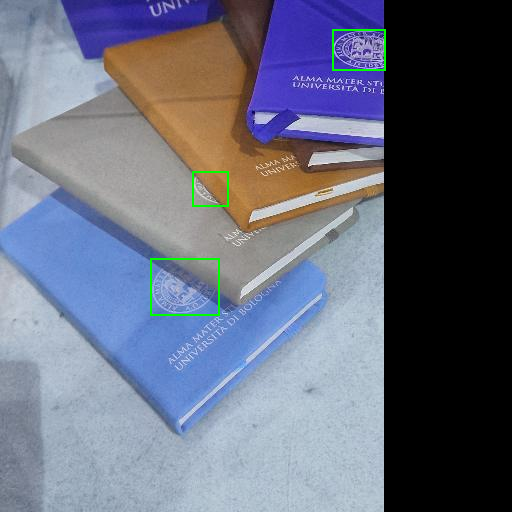

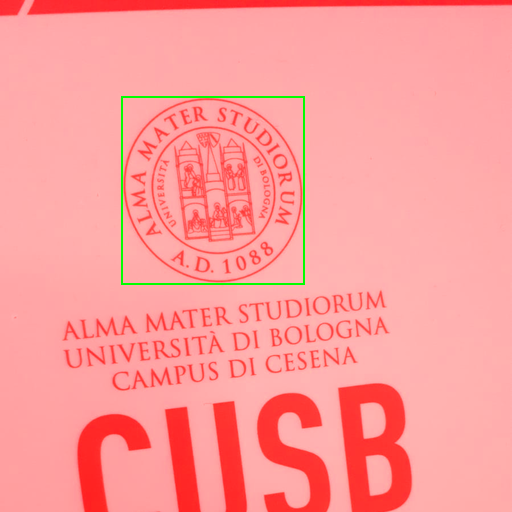

In [19]:
images=[]
bbss=[]
i=0

for img_path in train_img_files:
  image = imageio.imread(img_path)
  if image.shape[2] == 4:
    image = np.delete(image, 0, 2)
  images.append(image)
  bbs = BoundingBoxesOnImage([
      BoundingBox(x1=bb[0], x2=bb[2], y1=bb[1], y2=bb[3]) for bb in train_box_list[i]
  ], shape=image.shape)
  bbss.append(bbs)
  i+=1

  if i<=2:
    image_bbs = bbs.draw_on_image(image, size=2)
    cv2_imshow(image_bbs)

## Applicazione di filtri

1380


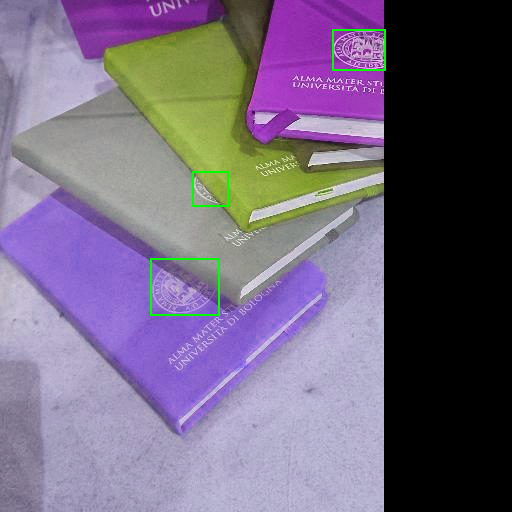

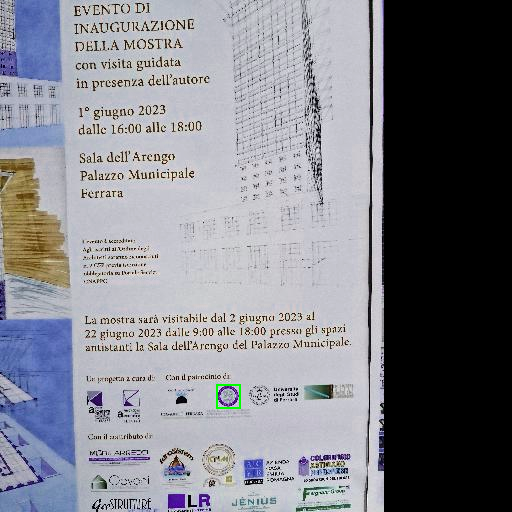

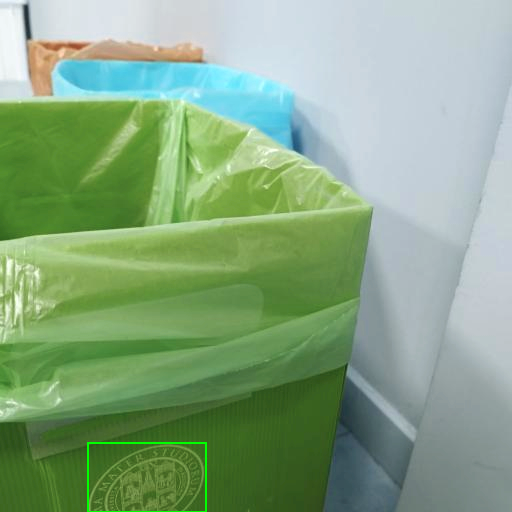

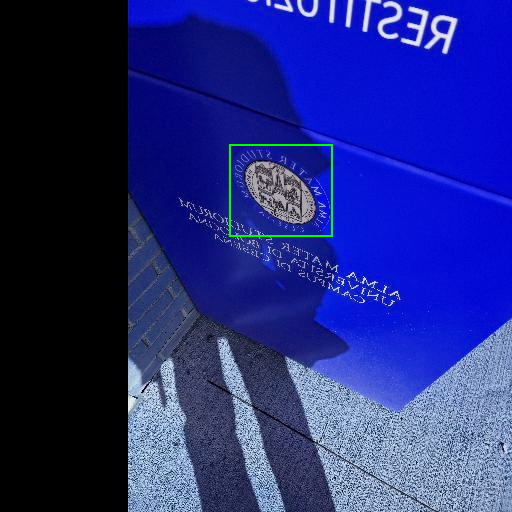

In [20]:
augColor = iaa.Sequential([
    iaa.WithColorspace(to_colorspace="HSV",from_colorspace="BGR",
        children=iaa.WithChannels(
        0,
        iaa.Add((0, 50))
    ))
])

augBrightness = iaa.Sequential([
    iaa.WithBrightnessChannels(iaa.Add((-50, 50)))
])

augFliplr = iaa.Sequential([
    iaa.Fliplr(1)
])

augFlipud = iaa.Sequential([
    iaa.Flipud(1)
])

images_aug, bbs_aug = augColor(images=images, bounding_boxes=bbss)
image_aug2, bbs_aug2 = augBrightness(images=images, bounding_boxes=bbss)
image_aug3, bbs_aug3 = augFliplr(images=images, bounding_boxes=bbss)
image_aug4, bbs_aug4 = augFlipud(images=images, bounding_boxes=bbss)


images_aug = images_aug + image_aug2 + image_aug3 + image_aug4
bbs_aug = bbs_aug + bbs_aug2 + bbs_aug3 + bbs_aug4

print(len(images_aug))

i=0
for img in images_aug:
  image_aug_bbs = bbs_aug[i].draw_on_image(img, size=2)
  if i==0 or i==249 or i==498 or i==747:
    cv2_imshow(image_aug_bbs)

  i+=1

# Salvataggio immagini e bounding box aumentate

In [21]:
data_aug_path = "data_aug"
images_aug_path = data_aug_path + "/images"
labels_aug_path = data_aug_path + "/labels"
if not os.path.exists(data_aug_path):
  os.makedirs(data_aug_path)
  os.makedirs(images_aug_path)
  os.makedirs(labels_aug_path)

In [22]:
images_aug_path_list = []
i = 0
for img_aug in images_aug:
  file_name = images_aug_path + '/aug'+ str(i) + '.jpg'
  images_aug_path_list.append(file_name)
  cv2.imwrite(file_name, img_aug)
  i+=1

In [23]:
labels_aug_path_list = []
i = 0
for bb_aug in bbs_aug:
  file_name = labels_aug_path + '/aug'+ str(i) + '.txt'
  labels_aug_path_list.append(file_name)
  with open(file_name, 'w') as label_aug:
    for bb in bb_aug.bounding_boxes:
      label_aug.write('1 ' + str(bb.x1) + " " + str(bb.y1) + " " + str(bb.x2) + " " + str(bb.y2) + '\n')
  i+=1

In [24]:
print(len(images_aug))
print(len(bbs_aug))

print(len(images_aug_path_list))
print(len(labels_aug_path_list))

1380
1380
1380
1380


# Caricamento dataset e suddivisione in train val e test

In [25]:
aug_imgs, aug_lables = load_images_paths_and_labels_paths_from_folder(data_aug_path)

train_img_files += aug_imgs
train_txt_files += aug_lables

from sklearn.utils import shuffle
train_img_files, train_txt_files = shuffle(train_img_files, train_txt_files, random_state=42)

train_img_files = list(np.array_split(train_img_files, 5))
train_txt_files = list(np.array_split(train_txt_files, 5))

print('Numero dei file di training: ',len(train_txt_files[0]))
print('Numero dei file di validation: ',len(val_txt_files))
# print('Numero dei file di test: ',len(test_txt_files))

print('Numero dei file di training: ',len(train_img_files[0]))
print('Numero dei file di validation: ',len(val_img_files))
# print('Numero dei file di test: ',len(test_img_files))

Numero dei file di training:  345
Numero dei file di validation:  62
Numero dei file di training:  345
Numero dei file di validation:  62


La cella sottostante permette di caricare in memoria i percorsi assoluti delle immagini e le rispettive annotazioni per i set di training, validation e test.

In [26]:
train_image_path_list = []
train_box_list = []
train_image_class_id_list = []
i = 0
for imgs in train_img_files:
  tipl, tbl, ticil = load_tlbr_dataset_info(train_txt_files[i], imgs)
  train_image_path_list.append(tipl)
  train_box_list.append(tbl)
  train_image_class_id_list.append(ticil)
  i += 1

val_image_path_list,val_box_list,val_image_class_id_list=load_tlbr_dataset_info(val_txt_files,val_img_files)
# test_image_path_list,test_box_list,test_image_class_id_list=load_tlbr_dataset_info(test_txt_files,test_img_files)

# print(train_image_path_list[0][0], val_image_path_list[0], test_image_path_list[0])

## **Visualizzazione dei dati**
Per capire meglio la natura e la difficoltà del problema che affronteremo può essere molto utile visualizzare alcune immagini di esempio. Eseguendo la cella sottostante verranno visualizzate quattro immagini del training set scelte casualmente (con le rispettive annotazioni).

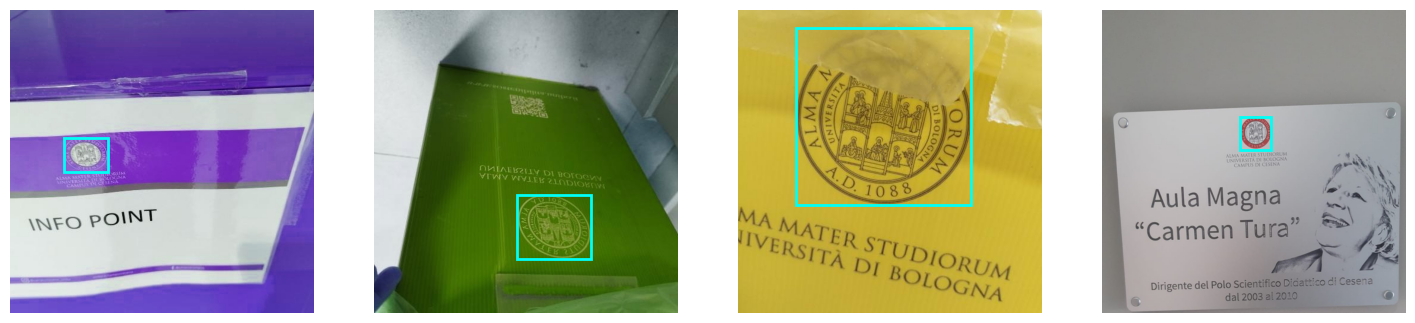

In [27]:
image_count=4
random_idx=random.randint(0,len(train_image_path_list[0])-image_count)

plot_images_with_tlbr([plt.imread(train_image_path_list[0][i]) for i in range(random_idx, random_idx+image_count)],
                      train_box_list[0][random_idx:random_idx+image_count],
                      train_image_class_id_list[0][random_idx:random_idx+image_count],
                      class_labels,
                      image_per_row=4,
                      show_labels=False)


## **Preparazione dei dati**
Quando si usano database di grosse dimensioni non sempre è possibile e conveniente caricarli interamente in memoria. Per ovviare a questo problema è possibile utilizzare la classe [**Dataset**](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) di TensorFlow che permette di gestire in maniera efficiente i dati caricandoli in memoria solo all'occorrenza.

Il metodo [**from_tensor_slices**](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices) crea un'istanza della classe **Dataset** partendo da un insieme di tensori che posseggono la prima dimensione con la medesima cardinalità.

Avendo memorizzato le informazioni dei set di training, validation e test in delle liste, prima di tutto dobbiamo convertirle in tensori. Le funzioni [**tf.constant**](https://www.tensorflow.org/api_docs/python/tf/constant) e  [**tf.ragged.constant**](https://www.tensorflow.org/api_docs/python/tf/ragged/constant) di TensorFlow creano rispettivamente un tensore e un tensore irregolare (ovvero che può avere delle dimensioni a lunghezza variabile) a partire da una lista. I tensori irregolari sono necessari in quanto il numero di *bounding box* può variare per ogni immagine.

In [28]:
train_data = []
i = 0
for imgs in train_image_path_list:
  train_data.append(
      tf.data.Dataset.from_tensor_slices((tf.constant(imgs),
                                                      tf.ragged.constant(train_box_list[i]),
                                                      tf.ragged.constant(train_image_class_id_list[i])))
      )
  i += 1

val_data = tf.data.Dataset.from_tensor_slices((tf.constant(val_image_path_list),
                                                     tf.ragged.constant(val_box_list),
                                                     tf.ragged.constant(val_image_class_id_list)))

# test_data = tf.data.Dataset.from_tensor_slices((tf.constant(test_image_path_list),
#                                                      tf.ragged.constant(test_box_list),
#                                                      tf.ragged.constant(test_image_class_id_list)))

La funzione **prepare_dataset** permette di preparare i dataset prima di utilizzarli nelle fasi di addestramento e valutazione delle prestazioni.

In [29]:
batch_size = 8


train_ds = []
for td in train_data:
  train_ds.append(prepare_dataset(td, batch_size, input_size))


val_ds=prepare_dataset(val_data,batch_size,input_size)
# test_ds=prepare_dataset(test_data,test_data.cardinality().numpy(),input_size)

La cella sottostante riporta il numero di *mini-batch* creati per ognuno dei tre dataset.

In [30]:
print('Mini-batch di training: ',train_ds[0].cardinality().numpy())
print('Mini-batch di validation: ',val_ds.cardinality().numpy())
# print('Mini-batch di test: ',test_ds.cardinality().numpy())

Mini-batch di training:  43
Mini-batch di validation:  7


Iterando su un Dataset è possibile ottenere un *mini-batch* per volta.

In [31]:
images, bounding_boxes =next(iter(train_ds[0]))

print('Shape del mini-batch delle immagini: ',images.shape)
print('Shape del mini-batch delle bounding box: ',bounding_boxes['boxes'].shape)
print('Shape del mini-batch delle classi associate alle bounding box: ',bounding_boxes['classes'].shape)

Shape del mini-batch delle immagini:  (8, 512, 512, 3)
Shape del mini-batch delle bounding box:  (8, None, 4)
Shape del mini-batch delle classi associate alle bounding box:  (8, None)


Grazie alla funzione **plot_images_with_xywh_bounding_boxes** è possibile visualizzare a video le immagini appartenenti a un *mini-batch* con evidenziate le *bounding box* associate.

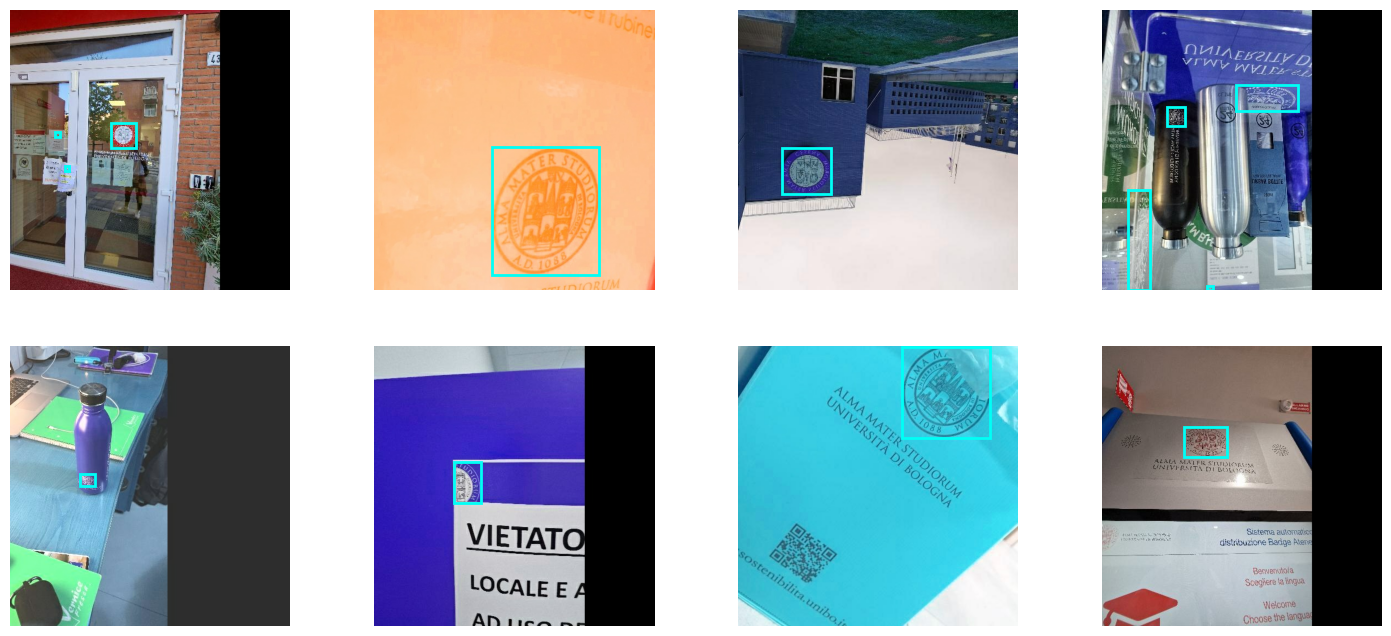

In [32]:
plot_images_with_tlbr(images/255,
                                     bounding_boxes['boxes'].to_list(),
                                     tf.dtypes.cast(bounding_boxes['classes'],tf.int32).to_list(),
                                     class_labels,
                                     image_per_row=4,
                                     show_labels=False)

# **Transfer learning**
L'addestramento di YOLOv8 su un nuovo problema, richiede un training set etichettato di notevoli dimensioni.

In alternativa al training da zero, possiamo utilizzare un modello pre-addestrato su un altro problema di *object detection* e effettuare [*fine-tuning*](https://en.wikipedia.org/wiki/Fine-tuning_(deep_learning)) sul nostro problema.


## **Caricamento del modello pre-addestrato**
Il metodo [**from_preset**](https://keras.io/api/keras_cv/models/backbones/yolo_v8/#frompreset-method) della classe [**YOLOV8Backbone**](https://keras.io/api/keras_cv/models/backbones/yolo_v8/#yolov8backbone-class) permette di istanziare una YOLOv8 caricando i pesi pre-addestrati su uno specifico dataset per poi utilizzarli in un altro contesto o su un altro *task*.

Eseguendo la cella sottostante verranno caricati i pesi ottenuti utilizzando in fase di addestramento il daset [**COCO**](https://cocodataset.org/).

In [33]:
yolov8_backbone = keras_cv.models.YOLOV8Backbone.from_preset('yolo_v8_m_backbone_coco',load_weights=True)

## **Creazione del modello**
Il codice seguente crea un'istanza della classe **YOLOV8Detector** utilizzando il *backbone* con i pesi pre-addestrati caricati nella cella precedente e impostando il numero di classi (*num_classes*) in base al problema che vogliamo affrontare.

In [34]:
# prediction_decoder = keras_cv.layers.NonMaxSuppression(
#   bounding_box_format="xyxy",
#   from_logits=True,
#   # Decrease the required threshold to make predictions get pruned out
#   iou_threshold=0.2,
#   # Tune confidence threshold for predictions to pass NMS
#   confidence_threshold=0.7,
# )

In [35]:
bb_format="xyxy"

In [36]:
yolov8_detector = keras_cv.models.YOLOV8Detector(backbone=yolov8_backbone,num_classes=len(class_labels),bounding_box_format=bb_format)

## **Configurare il modello per il training**
Con il metodo **compile** è possibile configurare il modello per la fase di training dati in input:
- un ottimizzatore (*optimizer*);
- la *loss* di classificazione (*classification_loss*);
- la *loss* di regressione delle *bounding box* (*box_loss*).

In particolare come *loss* di regressione delle *bounding box* viene utilizzata la **'ciou'** (*Complete Intersection over Union*), una variante della *Intersection over Union* (IoU).

In [37]:
# Configura il modello per il training
yolov8_detector.compile(optimizer='adam', classification_loss='binary_crossentropy', box_loss='ciou')

# **Training**
Ora siamo pronti per effettuare il *fine-tuning* della YOLOv8 utilizzando le immagini e le annotazioni dei dataset di training (*chess_train_ds*) e validation (*chess_val_ds*) per un numero di epoche pari a *epoch_count*.

In [38]:
# Numero di epoche di addestramento
epoch_count = 100

Per evitare che il modello faccia *overfitting* sul dataset di training, si può utilizzare la classe di *callback* [**EarlyStopping**](https://keras.io/api/callbacks/early_stopping/#earlystopping-class) che permette di interrompere l'addestramento quando la metrica monitorata smette di migliorare. I parametri da impostare sono:
- *monitor* la metrica da monitoriare;
- *patience* il numero di epoche consecutive in cui la metrica monitorata non migliora da attendere prima di interrompere l'addestramento;
- *restore_best_weights* permette di reimpostare i pesi all'epoca in la metrica monitorata ha ottenuto il valore migliore.

In [39]:
from google.colab import files

class EpochDots(tf.keras.callbacks.Callback):
  def __init__(self, report_every=100, save_threshold=2_000, save_prefix='model_'):
    self.report_every = report_every
    self.save_threshold = save_threshold
    self.save_prefix = save_prefix

  def on_epoch_end(self, epoch, logs):
    iacc = int(logs['val_loss']*100) #qui ci va l'etichetta per cui minimizzare o massimizzare
    if iacc < self.save_threshold: # < se minimizzo, > se massimizzo
      !rm -r model* #cancello il modello battuto, la prima volta non esiste e si lamenta ma funziona
      self.save_threshold = iacc
      self.model.save(f'{self.save_prefix}{iacc}')
      print(f'!! saved model for {iacc}')


    if epoch % self.report_every == 0:
      print('Epoch: {:d}, '.format(epoch), end='')
      for name, value in sorted(logs.items()):
        print('{}:{:0.4f}'.format(name, value), end=',  ')
      print()

## Per evitare che muoia durante il training

In [40]:
import gc

if 'augBrightness' in locals():
  del augBrightness
if 'augFliplr' in locals():
  del augFliplr
if 'augFlipud' in locals():
  del augFlipud
if 'aug_imgs' in locals():
  del aug_imgs
if 'aug_lables' in locals():
  del aug_lables
if 'base_path' in locals():
  del base_path
if 'bb' in locals():
  del bb
if 'bb_aug' in locals():
  del bb_aug
if 'bb_format' in locals():
  del bb_format
if 'bbs' in locals():
  del bbs
if 'bbs_aug' in locals():
  del bbs_aug
if 'bbs_aug1' in locals():
  del bbs_aug1
if 'bbs_aug2' in locals():
  del bbs_aug2
if 'bbs_aug3' in locals():
  del bbs_aug3
if 'bbs_aug4' in locals():
  del bbs_aug4
if 'bbss' in locals():
  del bbss
if 'bounding_boxes' in locals():
  del bounding_boxes
if 'checkpoint_dir' in locals():
  del checkpoint_dir
if 'checkpoint_path' in locals():
  del checkpoint_path
if 'data_aug_path' in locals():
  del data_aug_path
if 'file_name' in locals():
  del file_name
if 'i' in locals():
  del i
if 'id_list' in locals():
  del id_list
if 'image' in locals():
  del image
if 'image_aug1' in locals():
  del image_aug1
if 'image_aug2' in locals():
  del image_aug2
if 'image_aug3' in locals():
  del image_aug3
if 'image_aug4' in locals():
  del image_aug4
if 'image_aug_bbs' in locals():
  del image_aug_bbs
if 'image_bbs' in locals():
  del image_bbs
if 'image_count' in locals():
  del image_count
# if 'images' in locals():
#   del images
if 'images_aug' in locals():
  del images_aug
if 'images_aug_path' in locals():
  del images_aug_path
if 'images_aug_path_list' in locals():
  del images_aug_path_list
if 'img' in locals():
  del img
if 'img_aug' in locals():
  del img_aug
if 'img_paths' in locals():
  del img_paths
if 'input_size' in locals():
  del input_size
if 'label_aug' in locals():
  del label_aug
if 'labels' in locals():
  del labels
if 'labels_aug_path' in locals():
  del labels_aug_path
if 'labels_aug_path_list' in locals():
  del labels_aug_path_list
if 'path_images' in locals():
  del path_images
if 'path_labels' in locals():
  del path_labels
if 'random_idx' in locals():
  del random_idx
if 'test_box_list' in locals():
  del test_box_list
# if 'test_data' in locals():
#   del test_data
if 'test_image_class_id_list' in locals():
  del test_image_class_id_list
if 'test_image_path_list' in locals():
  del test_image_path_list
if 'test_img_files' in locals():
  del test_img_files
if 'tlbr_boxes' in locals():
  del tlbr_boxes
if 'train_box_list' in locals():
  del train_box_list
# if 'train_data' in locals():
#   del train_data
if 'train_image_class_id_list' in locals():
  del train_image_class_id_list
if 'train_image_path_list' in locals():
  del train_image_path_list
if 'train_img_files' in locals():
  del train_img_files
if 'train_txt_files' in locals():
  del train_txt_files
if 'val_box_list' in locals():
  del val_box_list
# if 'val_data' in locals():
#   del val_data
if 'val_image_class_id_list' in locals():
  del val_image_class_id_list
if 'val_image_path_list' in locals():
  del val_image_path_list
if 'val_img_files' in locals():
  del val_img_files
if 'val_txt_files' in locals():
  del val_txt_files

gc.collect()


769

# Training
Nella cella seguente viene richiamato il metodo [**fit**](https://keras.io/api/models/model_training_apis/#fit-method) che esegue l'intera fase di addestramento in maniera automatica monitorando costantemente la *loss function* su training e validation set.

In [41]:
callback = EpochDots(report_every=20, save_threshold=150, save_prefix=f'model_')
for tds in train_ds:
  history = yolov8_detector.fit(tds, validation_data=val_ds,
                      epochs=epoch_count, batch_size=batch_size, shuffle=False,
                      verbose=1,
                      callbacks=[callback]
                      )

Epoch 1/100
43/43 [==============================] - 81s 279ms/step - loss: 203.8521 - box_loss: 3.1359 - class_loss: 200.7162 - val_loss: 89.3692 - val_box_loss: 0.4688 - val_class_loss: 88.9004
Epoch 2/100
43/43 [==============================] - 10s 211ms/step - loss: 52.7635 - box_loss: 3.1542 - class_loss: 49.6093 - val_loss: 171.9093 - val_box_loss: 3.3343 - val_class_loss: 168.5750
Epoch 3/100
43/43 [==============================] - 10s 210ms/step - loss: 25.1163 - box_loss: 3.0016 - class_loss: 22.1147 - val_loss: 26.8786 - val_box_loss: 3.1815 - val_class_loss: 23.6971
Epoch 4/100
43/43 [==============================] - 9s 192ms/step - loss: 15.8312 - box_loss: 2.9871 - class_loss: 12.8441 - val_loss: 18.0259 - val_box_loss: 3.4931 - val_class_loss: 14.5328
Epoch 5/100
43/43 [==============================] - 10s 206ms/step - loss: 11.9126 - box_loss: 2.9739 - class_loss: 8.9387 - val_loss: 13.4578 - val_box_loss: 3.5854 - val_class_loss: 9.8724
Epoch 6/100
43/43 [==========

In [42]:
!zip -r model_part1.zip model_*
from google.colab import files
files.download('model_part1.zip')

  adding: model_99/ (stored 0%)
  adding: model_99/saved_model.pb (deflated 92%)
  adding: model_99/variables/ (stored 0%)
  adding: model_99/variables/variables.index (deflated 79%)
  adding: model_99/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: model_99/assets/ (stored 0%)
  adding: model_99/keras_metadata.pb (deflated 95%)
  adding: model_99/fingerprint.pb (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [43]:
yolov8_detector.save('model.keras')

In [46]:
np.random.shuffle(train_ds)

In [47]:
for tds in train_ds:
  history = yolov8_detector.fit(tds, validation_data=val_ds,
                      epochs=epoch_count//2, batch_size=batch_size, shuffle=True,
                      verbose=1,
                      callbacks=[callback]
                      )

Epoch 1/50
43/43 [==============================] - 10s 216ms/step - loss: 0.7474 - box_loss: 0.4776 - class_loss: 0.2698 - val_loss: 2.5785 - val_box_loss: 1.4331 - val_class_loss: 1.1455
Epoch 2/50
43/43 [==============================] - 10s 214ms/step - loss: 0.7850 - box_loss: 0.5103 - class_loss: 0.2747 - val_loss: 4.4379 - val_box_loss: 2.2470 - val_class_loss: 2.1910
Epoch 3/50
43/43 [==============================] - 10s 214ms/step - loss: 0.5972 - box_loss: 0.4023 - class_loss: 0.1950 - val_loss: 1.6919 - val_box_loss: 1.0427 - val_class_loss: 0.6492
Epoch 4/50
43/43 [==============================] - 10s 218ms/step - loss: 0.4880 - box_loss: 0.3433 - class_loss: 0.1447 - val_loss: 1.2071 - val_box_loss: 0.7623 - val_class_loss: 0.4448
Epoch 5/50
43/43 [==============================] - 10s 199ms/step - loss: 0.4463 - box_loss: 0.3178 - class_loss: 0.1286 - val_loss: 1.1672 - val_box_loss: 0.7558 - val_class_loss: 0.4114
Epoch 6/50
43/43 [==============================] - 11s

Il metodo **fit** restituisce un oggetto (*history*) che contiene per ogni epoca i valori della *loss function* sia per il training sia per il validation set.

Richiamando la funzione **plot_history** è possibile graficare tali valori.

In [ ]:
plot_history(history)

# Salvataggio modello


In [48]:
!zip -r model_final.zip model_*
from google.colab import files
files.download('model_final.zip')

  adding: model_87/ (stored 0%)
  adding: model_87/saved_model.pb (deflated 92%)
  adding: model_87/variables/ (stored 0%)
  adding: model_87/variables/variables.index (deflated 79%)
  adding: model_87/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: model_87/assets/ (stored 0%)
  adding: model_87/keras_metadata.pb (deflated 95%)
  adding: model_87/fingerprint.pb (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [50]:
!cp /content/model_final.zip /content/drive/MyDrive/VAR-challenge/